# Load libraries

In [1]:
library(Seurat)
library(Signac)
library(Matrix)
library(readr)
library(ggplot2)
library(data.table)
library(GenomicRanges)
library(dplyr)
library(rtracklayer)

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t


Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: generics


Attaching package: ‘generics’


The following objects are masked from ‘package:base’:

    as.difftime, as.factor, as.ordered, intersect, is.element, setdiff,
    setequal, union



Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    Filter, Find, Map, Position, Reduce, anyDuplicated, aperm, append,
    as.data.frame, basename, cbind, colnames, dirname, do.call,
    duplicated, eval, evalq, get, grep, grepl, is.unsorted, lapply,
    mapply, match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    rank, rbind, rownames, sapply, saveRDS, table, tapply, unique,
    uns

# Step 1: Load sparse matrix and convert to full matrix

Use the dataset: "PBMCs 3k cells from a healthy donor"
* Use the material provided as part of the exam.

Matrix conversion
* Use the Matrix R package to convert the sparse matrix into a full matrix.
* Save the result as a data.table object.


In [2]:
# Step 1 ___________________________________________________________________________
s1.make.dt <- function(
    data_path = "/sharedFolder/Data/matrix/"
) {
    # Load the sparse matrix
    matrix <- readMM(file = paste0(data_path, "matrix.mtx.gz"))
    features <- read_tsv(file = paste0(data_path, "features.tsv.gz"), 
                         col_names = c("id", "name", "type", "chr", "start", "end"), 
                         show_col_types = F)
    barcodes <- read_tsv(file = paste0(data_path, "barcodes.tsv.gz"), 
                         col_names = F, 
                         show_col_types = F) 

    # Assign names to colums and rows and transform the object "matrix" in a matrix
    colnames(matrix) <- barcodes$X1
    rownames(matrix) <- features$id
    matrix <- as.matrix(matrix)

    # Genearate a data.table, a id columns containg the ids of the various genes/peaks is added 
    dt <- as.data.table(matrix, row.names = rownames(matrix))
    dt[, id := rownames(matrix)]
    setcolorder(dt, c("id", setdiff(names(dt), "id"))) # id is put as the first column


    return(dt)
}

In [3]:
dt <- s1.make.dt(data_path = "/sharedFolder/Data/matrix/")

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.6 GiB”


# Step 2: Split gene expression and ATAC-seq data

From the data.table object, separate:
* Gene expression data (rows labelled with Ensembl gene IDs, e.g., ENSG00000243485)
* ATAC-seq peak data (rows labelled with genomic coordinates, e.g., chrN:NNNN-NNNN)


In [4]:
# Step 2 ___________________________________________________________________________
s2.subset.dt <- function(
    string,
    data
) {
    # Use grepl to create a logic that indicates which elemnent of the data.table to take
    sub <- data[grepl(string, data$id)]
    return(sub)
}

In [5]:
dt_genes <- s2.subset.dt(string = "ENSG", data = dt)
dt_atac <- s2.subset.dt(string = "chr", data = dt)

# Step 3: Summarize Data

For each dataset (expression and peaks), compute the column-wise sum to produce:
* A single vector of total expression per gene
* A single vector of total chromatin accessibility per peak region

In [6]:
# Step 3 ___________________________________________________________________________
s3.summarize.data <- function(
    data
) {
    summary <- data[, rowSums(.SD), .SDcols = -"id"]
    names(summary) <- data$id
    return(summary)
}

In [7]:
genes_summary <- s3.summarize.data(data = dt_genes)
atac_summary <- s3.summarize.data(data = dt_atac)

# Step 4: Create GenomicRanges

* Convert both the summarized gene expression and peak data into GenomicRanges objects.
* Add the summarized data as metadata to their respective GenomicRanges.

In [8]:
# Step 4 ___________________________________________________________________________
s4.create.GenomicRanges <- function(
    type,
    path_f = "/sharedFolder/Data/matrix/features.tsv.gz"
) {
    # Load Features
    features <- as.data.table(
        read_tsv(
            file = path_f, 
            col_names = c("id", "name", "type", "chr", "start", "end"), 
            show_col_types = F
        )
    )

    # Subset features for genes or peaks
    if (type %in% c("Genes", "genes")) {
        if (type != "Genes") {type = "Genes"}
        
        features <- features[grepl("Gene", features$type)]
        features$chr[is.na(features$chr)] <- "unknown"

        summary = genes_summary
    } else if (type %in% c("Peaks", "peaks", "ATAC", "Atac", "atac")) {
        if (type != "Peaks") {type = "Peaks"}
        
        features <- features[grepl("Peaks", features$type) & grepl("chr", features$chr)]
        features$chr[is.na(features$chr)] <- "unknown"

        summary = atac_summary
    } else {
        print("Error, invalid value for type: must be 'Gene' or 'Peaks'")
        return ("")
    }

    # Create GRanges object
    gr <- GRanges(
        seqnames = features$chr,
        ranges = IRanges(
            start = features$start,
            end = features$end
        )
    )

    # Add metadata 
    if (type == "Genes") {
        gr$gene_sum = summary
        gr$gene_id <- features$id
        gr$gene_name <- features$name
    } else if (type == "Peaks") {
        gr$peak_sum = summary
        gr$peak_id <- features$id
    }

    return(gr)
}

In [9]:
gr_genes <- s4.create.GenomicRanges("genes")
gr_atac <- s4.create.GenomicRanges("atac")

# Step 5: Gene Annotation for ATACseq data

Using the annotation file Homo_sapiens.GRCh38.114.gtf.gz:
* Create a GenomicRanges object only for protein-coding genes and only for gene features.
* Remap the ATAC-seq GenomicRanges to this object and attach the summarized peak data from step 4.

## Create GFT

In [10]:
# Step 5 ___________________________________________________________________________
s5.GR.protein.coding <- function(
    path = "/sharedFolder/Data/Homo_sapiens.GRCh38.114.gtf.gz"
) {
    # Import the GTF file
    data <- rtracklayer::import("Data/Homo_sapiens.GRCh38.114.gtf.gz")

    # Standardize the names (in the files the chromosomes are called by number/letter)
    seqlevels(data) <- ifelse(
        grepl(
            "^([1-9]|1[0-9]|2[0-2]|X|Y)$", # [1-22] would not work but just check from 1 to 2, with the second 2 ignored
            seqlevels(data)
        ), 
        paste0(
            "chr", 
            seqlevels(data)
        ), 
        seqlevels(data)
    )

    # Filter for protein coding genes
    data_coding <- data[data$type == "gene" & data$gene_biotype == "protein_coding"]

    return(data_coding)
}

In [11]:
h38_coding <- s5.GR.protein.coding()

## Remap ATAC

In [12]:
s5.remap.atac <- function(
    atac_data = gr_atac
) {
    # Find the atac peaks that overlap with coding genes
    overlaps <- findOverlaps(atac_data, h38_coding)
    
    # Create a list of the genes for which there is an overlap
    gene_list <- split(h38_coding$gene_id[subjectHits(overlaps)], queryHits(overlaps))
    
    # Assign the genes to the corresponding peaks
    # In the case a peak is overlapping multiple genes they are added as a comma separated list
    atac_data$overlapping_genes <- NA
    atac_data$overlapping_genes[as.integer(names(gene_list))] <- sapply(gene_list, paste, collapse = ",") 

    return(atac_data)
}

In [13]:
gr_atac <- s5.remap.atac()

# Step 6: Finalize expression data

* Subset the expression GenomicRanges, step 4, to include only protein-coding genes.
* Add gene symbol identifiers to the object.

In [14]:
# Step 6 ___________________________________________________________________________
s6.finalize.exp.data <- function(
    exp_data = gr_genes
) {
    # Add a column to with gene symbols by matching the gene_id to the annotation from the GTF file
    exp_data$gene_symbol <- h38_coding$gene_name[match(exp_data$gene_id, h38_coding$gene_id)]

    # # Remove rows where gene_symbol is NA
    exp_data <- exp_data[!is.na(exp_data$gene_symbol)]

    return(exp_data)
}

In [15]:
gr_genes <- s6.finalize.exp.data()

# Step 7: Data Normalization and Integration

* Normalize both expression and ATAC-seq data using CPM:
    * Divide each column by the column sum, multiply by 106, add a pseudo-count of 1, and apply log2.
* Merge expression and ATAC data based on common genes.
* Provide a summary table of the number of ATAC peaks that could not be merged and a plot of peak intensity distribution chromosome by chromosome. Provide a summary table of the genes which do not show association with ATAC peaks and plot their expression distribution chromosome by chromosome

## Normalize cpm

In [16]:
# Step 7 ___________________________________________________________________________
# Step 7 - Normalize _______________________________________________________________
s7.normalize.cmp <- function(
    data
) {
    # remove id column
    matrix <- as.matrix(data[ , -'id', with=FALSE])
    
    cpm <- t(t(matrix) / colSums(matrix)) * 1e6
    cpm <- log2(cpm + 1)  # log with pseudocount

    return(cpm)
}

In [17]:
gene_cpm <- s7.normalize.cmp(data = dt_genes)
atac_cmp <- s7.normalize.cmp(data = dt_atac)

## Merge

In [18]:
# Step 7 - Merge ___________________________________________________________________
s7.merge <- function(
    exp_data = gr_genes,
    atac_data = gr_atac
) {
    merged <- merge(
      as.data.table(exp_data)[, .(gene_id, gene_symbol, seqnames, gene_sum = gene_sum)],
      as.data.table(atac_data)[, .(overlapping_genes, peak_sum = peak_sum)],
      by.x = "gene_id", by.y = "overlapping_genes", all.x = TRUE
    )
    colnames(merged)[colnames(merged) == "seqnames"] <- "chr"

    return(merged)
}

In [19]:
merged_data <- s7.merge()

## Summary

In [20]:
# Step 7 - Summary _________________________________________________________________
s7.summary.table.peaks <- function(
    atac_data = gr_atac
) {
    unmerged <- as.data.table(atac_data)[is.na(overlapping_genes)]
    unmerged<- unmerged[, .(peak_id, seqnames, start, end, peak_sum)]
    colnames(unmerged)[colnames(unmerged) == "seqnames"] <- "chr"
        
    return(unmerged)
}

In [21]:
unmerged_peaks <- s7.summary.table.peaks()

In [22]:
s7.summary.table.genes <- function(
    exp_data = gr_genes,
    merged = merged_data
) {
    genes_no_atac <- merged[is.na(peak_sum) | peak_sum == 0]
    genes_no_atac <- genes_no_atac[, .(gene_id, gene_symbol, gene_sum)]
    
    return(genes_no_atac)
}

In [23]:
genes_no_atac <- s7.summary.table.genes()

In [24]:
s7.summary.plot.peaks <- function(
    data_merged = merged_data,
    data_unmerged = unmerged_peaks
) {
    # Provide "a plot of peak intensity distribution chromosome by chromosome"
    # For peaks that could be merged or for the ones that could not?
    

    merged <- ggplot(data_merged[!is.na(peak_sum)], aes(x=chr, y=peak_sum)) + 
        geom_boxplot() + theme(axis.text.x = element_text(angle=90)) +
        labs(title = "Peak intensity distribution for merged peaks")

    unmerged <- ggplot(data_unmerged[!is.na(peak_sum)], aes(x=chr, y=peak_sum)) + 
        geom_boxplot() + theme(axis.text.x = element_text(angle=90)) +
        labs(title = "Peak intensity distribution for unmerged peaks")
    
    #Save
    dir_results <- "/sharedFolder/Results"
    if (!dir.exists(dir_results)) {dir.create(dir_results)}
    
    ggsave("/sharedFolder/Results/s7_peaks_intesnisty_merged.png", plot = merged)
    ggsave("/sharedFolder/Results/s7_peaks_intesnisty_unmerged.png", plot = unmerged)
    
    return(list(merged, unmerged))
}

In [25]:
plot_s7_pea <- s7.summary.plot.peaks()

Saving 7 x 7 in image
Saving 7 x 7 in image


In [26]:
s7.summary.plot.genes <- function(
    data = merged_data
) {
    plot <- list()
    
    # atac
    data_atac <- data[peak_sum > 0 & grepl("chr", data$chr)]
    merged <- ggplot(data_atac, aes(x=chr, y=gene_sum)) + 
        geom_boxplot() + theme(axis.text.x = element_text(angle=90)) +
        labs(title = "Expression of Genes with ATAC Peaks")
    
    # no atac
    data_no_atac <- data[(is.na(peak_sum)| peak_sum == 0) & grepl("chr", data$chr)]
    unmerged <- ggplot(data_no_atac, aes(x=chr, y=gene_sum)) + 
        geom_boxplot() + theme(axis.text.x = element_text(angle=90)) +
        labs(title = "Expression of Genes without ATAC Peaks")

    #Save
    dir_results <- "/sharedFolder/Results"
    if (!dir.exists(dir_results)) {dir.create(dir_results)}
    
    ggsave("/sharedFolder/Results/s7_gene_expression_merged.png", plot = merged)
    ggsave("/sharedFolder/Results/s7_gene_expression_unmerged.png", plot = unmerged)
    
    return(list(merged, unmerged))
}

In [27]:
plot_s7_genes <- s7.summary.plot.genes(merged_data)


Saving 7 x 7 in image
Saving 7 x 7 in image


In [28]:
s7.summary.chr.wise <- function(

) {
    peak_chr_summary <- unmerged_peaks[, .N, by = chr]
    colnames(peak_chr_summary) <- c("chr", "N_unmerged_peaks")
    
    gr_genes_dt <- as.data.table(gr_genes)
    genes_no_atac <- merge(genes_no_atac, gr_genes_dt[, .(gene_id, seqnames)], by = "gene_id", all.x = TRUE)
    gene_chr_summary <- genes_no_atac[, .N, by = seqnames] 
    colnames(gene_chr_summary) <- c("chr", "N_unmerged_genes")
    
    chr_wise_summary <- merge(gene_chr_summary,peak_chr_summary, all = T)

    return(chr_wise_summary)
}

In [29]:
chr_wise_summary <- s7.summary.chr.wise()
print(chr_wise_summary)

Key: <chr>
           chr N_unmerged_genes N_unmerged_peaks
        <fctr>            <int>            <int>
 1:       chr1              607             3038
 2:       chr2              354             2444
 3:       chr3              303             1636
 4:       chr4              260             1092
 5:       chr5              319             1520
 6:       chr6              329             2007
 7:       chr7              280             1361
 8:       chr8              213             1283
 9:       chr9              243             1243
10:      chr10              193             1381
11:      chr11              538             1304
12:      chr12              311             1469
13:      chr13               81              740
14:      chr14              202             1098
15:      chr15              168              889
16:      chr16              274              807
17:      chr17              359             1404
18:      chr18               67              533
19:      

# Step 8: Visualization

* Generate a scatter plot using ggplot2:
    * X-axis: log-transformed expression CPM
    * Y-axis: log-transformed ATAC CPM
* If the plot is too much busy of data divide the plot in the 24 chromosomes

In [39]:
# Step 8 ___________________________________________________________________________
s8.scatter.plots <- function(chr_num) {
    plot <- ggplot(
        merged_data[!is.na(peak_sum) & merged_data$chr == paste0("chr", chr_num)], 
        aes(x=log2(gene_sum), y=log2(peak_sum))
    ) +
      geom_point(alpha=0.5) +
      labs(
          x = "Gene Expression CPM (log2)", 
          y = "ATAC Peaks CPM (log2)", 
          title = paste("Chromosme", chr_num)
      ) +
      #facet_wrap(~ chr) +
      theme_bw() +
      theme(axis.text.x = element_text(angle = 45, hjust = 1))
    return(plot)
}

In [31]:
s8.save.plots <- function() {
    plot_list <- lapply(c(as.character(1:22), "X", "Y"), s8.scatter.plots)

    dir_results <- "/sharedFolder/Results"
    if (!dir.exists(dir_results)) {dir.create(dir_results)}

    for (i in 1:(length(plot_list)/12)) {
        n <- 12*(i-1)+1
        combined <- cowplot::plot_grid(plotlist = plot_list[(n):(n+11)], ncol = 3) 
        ggsave(paste0(
            "/sharedFolder/Results/s8_plot_",
            i,
            ".png"
        ), plot = combined, width = 1920*2, height = 1080*3.6, units = "px")
    }
}

In [32]:
s8.save.plots()

[[1]]


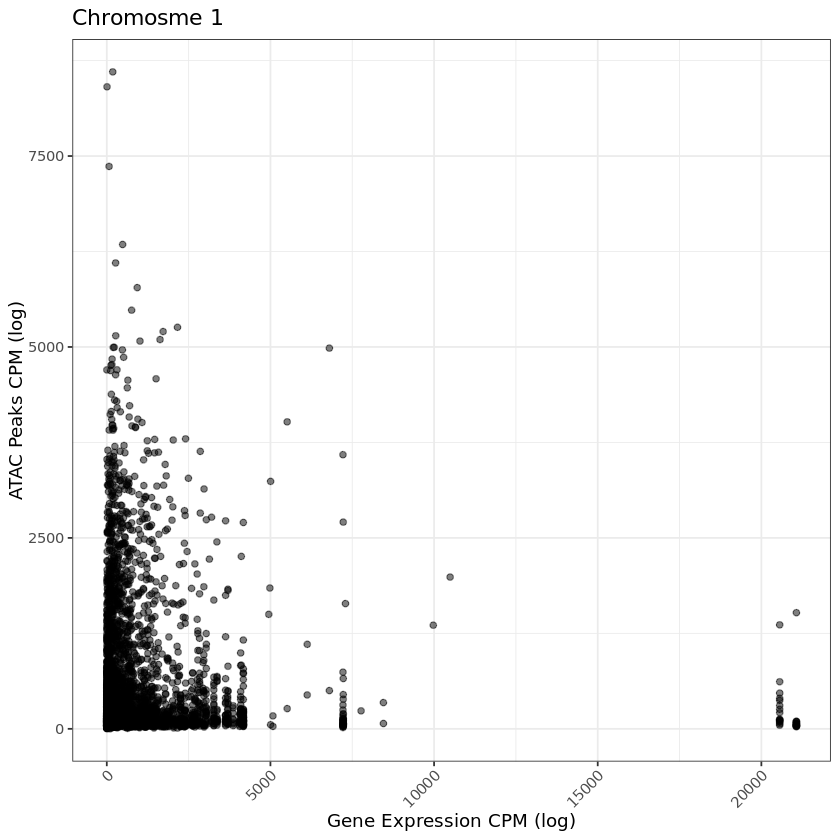

In [36]:
plot_list <- lapply(c(as.character(1:22), "X", "Y"), s8.scatter.plots)
plot_list[1]

[[1]]


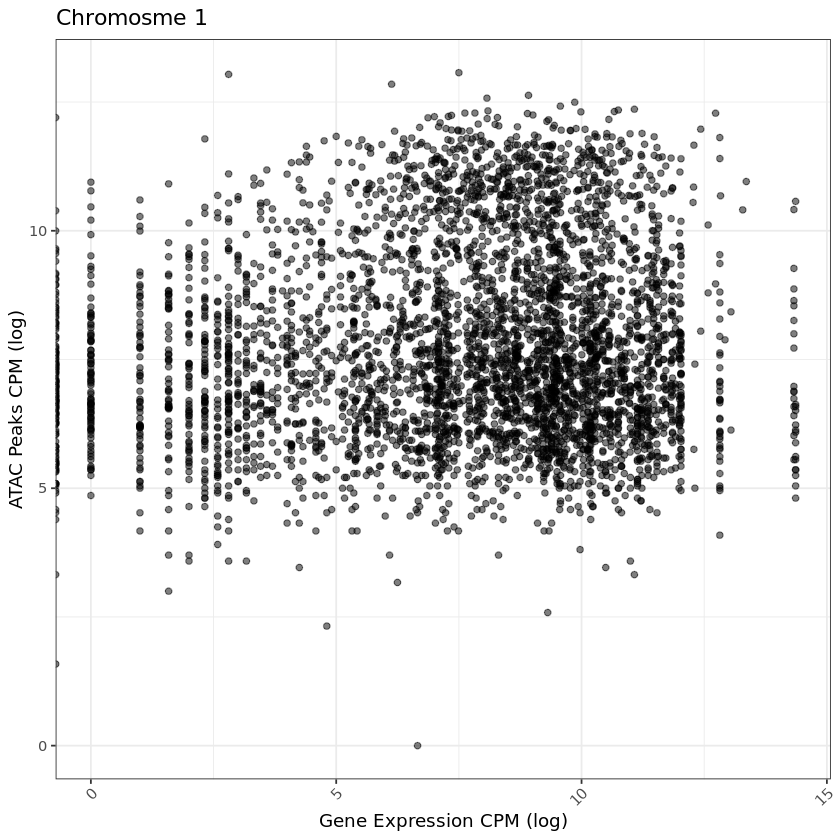

In [38]:
plot_list <- lapply(c(as.character(1:22), "X", "Y"), s8.scatter.plots)
plot_list[1]

# R Markdown

In [33]:
#install.packages("tinytex")
#tinytex::install_tinytex()

In [34]:
rmarkdown::render("Maiolino_Au.Rmd")



processing file: Maiolino_Au.Rmd



1/30                   
2/30 [unnamed-chunk-1] 
3/30                   
4/30 [unnamed-chunk-2] 
5/30                   
6/30 [unnamed-chunk-3] 
7/30                   
8/30 [unnamed-chunk-4] 
9/30                   
10/30 [unnamed-chunk-5] 
11/30                   
12/30 [unnamed-chunk-6] 
13/30                   
14/30 [unnamed-chunk-7] 
15/30                   
16/30 [unnamed-chunk-8] 
17/30                   
18/30 [unnamed-chunk-9] 
19/30                   
20/30 [unnamed-chunk-10]
21/30                   
22/30 [unnamed-chunk-11]
23/30                   
24/30 [unnamed-chunk-12]
25/30                   
26/30 [unnamed-chunk-13]
27/30                   
28/30 [unnamed-chunk-14]
29/30                   
30/30 [unnamed-chunk-15]


output file: Maiolino_Au.knit.md




/usr/bin/pandoc +RTS -K512m -RTS Maiolino_Au.knit.md --to latex --from markdown+autolink_bare_uris+tex_math_single_backslash --output Maiolino_Au.tex --lua-filter /usr/local/lib/R/site-library/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /usr/local/lib/R/site-library/rmarkdown/rmarkdown/lua/latex-div.lua --self-contained --table-of-contents --toc-depth 2 --highlight-style tango --pdf-engine pdflatex --variable graphics --include-in-header /tmp/Rtmp4tTmtZ/rmarkdown-str50f1569dd2e6.html --variable 'geometry:margin=1in' 



Output created: Maiolino_Au.pdf

